In [5]:
import pandas as pd
import numpy as np
import pubchempy as pcp
import ssl

from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold

In [6]:
ssl._create_default_https_context = ssl._create_unverified_context

# Define Helper Functions
We define two helper functions:
1. `get_smiles_from_pubchem(compound_name)`: Fetches the **SMILES representation** of a compound from PubChem.
2. `smiles_to_ecfp(smiles)`: Converts a **SMILES string** into an **ECFP (Extended-Connectivity Fingerprint)**.
These functions will help us convert chemical names into numerical representations suitable for machine learning.


In [10]:
def get_smiles_from_pubchem(compound_name):
    """Fetch canonical SMILES for a compound name from PubChem."""
    try:
        compound = pcp.get_compounds(compound_name, 'name')
        if compound:
            return compound[0].canonical_smiles
    except Exception as e:
        print(f"Error fetching SMILES for {compound_name}: {e}")
    return None

def smiles_to_ecfp(smiles, radius=2, n_bits=2048):
    """Generate ECFP (Morgan) fingerprint as a list of bits (0/1) from a SMILES string."""
    try:
        if smiles:
            mol = Chem.MolFromSmiles(smiles)
            if mol:
                generator = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=n_bits)
                fp = generator.GetFingerprint(mol)
                return list(fp)
            else:
                print(f"Invalid SMILES: {smiles}")
        else:
            print("SMILES is None, skipping...")
    except Exception as e:
        print(f"Error generating ECFP for SMILES {smiles}: {e}")
    return None

# Load Dataset
We load the dataset containing information about different chemical compounds.
We'll take a look at the first few rows to understand its structure.

In [11]:
# Load the dataset
df = pd.read_csv('dataset.csv')

# Show the first 5 rows
df.head()

,id,compound_name,species,strain,dosage,age_at_initiation,treatment_duration,avg_lifespan_change_percent,avg_lifespan_significance,max_lifespan_change_percent,max_lifespan_significance,gender_new,weight_change_percent,weight_change_significance,ITP,pubmed_id,notes,last_modified
0,1731,Glucomannan Hydrolysate,Drosophila melanogaster,B18,0.25% w/v,NaN,NaN,20.20,S,NaN,NaN,Male,NaN,NaN,No,30252027,NaN,2024-10-12 09:39:44
1,1732,Glucomannan Hydrolysate,Drosophila melanogaster,B18,0.25% w/v,NaN,NaN,14.88,S,NaN,NaN,Female,NaN,NaN,No,30252027,NaN,2024-10-12 09:39:34
2,1734,Glucomannan Hydrolysate,Drosophila melanogaster,Canton-S,0.25% w/v,NaN,NaN,17.66,S,NaN,NaN,Female,NaN,NaN,No,30252027,NaN,2024-10-12 09:39:22
3,1733,Glucomannan Hydrolysate,Drosophila melanogaster,Oregon-R,0.25% w/v,NaN,NaN,11.70,S,NaN,NaN,Female,NaN,NaN,No,30252027,NaN,2024-10-12 09:39:06
4,1735,Glucomannan Hydrolysate,Drosophila melanogaster,DGRP-21,0.25% w/v,NaN,NaN,13.40,S,NaN,NaN,Female,NaN,NaN,No,30252027,NaN,2024-10-12 09:38:47


# Convert Compound Names to SMILES and Generate ECFP
We iterate through each compound name in our dataset, retrieve its SMILES notation using PubChem, 
and convert it into an ECFP fingerprint using RDKit.


In [12]:
# Take a small subset of 2000 rows for testing
df_small = df.iloc[:2000].copy()

# Initialize new columns for SMILES and ECFP fingerprints
df_small['smiles'] = None
df_small['ecfp'] = None

# Convert compound names to SMILES and ECFP fingerprints
for idx, row in df_small.iterrows():
    compound_name = row['compound_name']
    smiles = get_smiles_from_pubchem(compound_name)
    df_small.at[idx, 'smiles'] = smiles
    
    if smiles:
        ecfp_bits = smiles_to_ecfp(smiles)
        df_small.at[idx, 'ecfp'] = ecfp_bits

# Show a preview of the updated data
df_small.head()

Error fetching SMILES for Rhodiola rosea extract: 'PUGREST.ServerBusy'
Error fetching SMILES for Black tea extract: 'PUGREST.ServerBusy'
Error fetching SMILES for Hydrocortisone acetate: 'PUGREST.ServerBusy'
Error fetching SMILES for p-coumaric acid: 'PUGREST.ServerBusy'
Error fetching SMILES for Dimethylaminoethyl p-chlorophenoxyacetate: 'PUGREST.ServerBusy'


,id,compound_name,species,strain,dosage,age_at_initiation,treatment_duration,avg_lifespan_change_percent,avg_lifespan_significance,max_lifespan_change_percent,max_lifespan_significance,gender_new,weight_change_percent,weight_change_significance,ITP,pubmed_id,notes,last_modified,smiles,ecfp
0,1731,Glucomannan Hydrolysate,Drosophila melanogaster,B18,0.25% w/v,NaN,NaN,20.20,S,NaN,NaN,Male,NaN,NaN,No,30252027,NaN,2024-10-12 09:39:44,None,None
1,1732,Glucomannan Hydrolysate,Drosophila melanogaster,B18,0.25% w/v,NaN,NaN,14.88,S,NaN,NaN,Female,NaN,NaN,No,30252027,NaN,2024-10-12 09:39:34,None,None
2,1734,Glucomannan Hydrolysate,Drosophila melanogaster,Canton-S,0.25% w/v,NaN,NaN,17.66,S,NaN,NaN,Female,NaN,NaN,No,30252027,NaN,2024-10-12 09:39:22,None,None
3,1733,Glucomannan Hydrolysate,Drosophila melanogaster,Oregon-R,0.25% w/v,NaN,NaN,11.70,S,NaN,NaN,Female,NaN,NaN,No,30252027,NaN,2024-10-12 09:39:06,None,None
4,1735,Glucomannan Hydrolysate,Drosophila melanogaster,DGRP-21,0.25% w/v,NaN,NaN,13.40,S,NaN,NaN,Female,NaN,NaN,No,30252027,NaN,2024-10-12 09:38:47,None,None


# Data Cleaning
We remove:
1. Rows where the **target variable** (`avg_lifespan_change_percent`) is missing.
2. Rows that do not have **ECFP fingerprints**.
This ensures our dataset is complete before training a machine learning model.

In [14]:
target_col = 'avg_lifespan_change_percent'

# Drop rows missing the target or ECFP fingerprint
df_small = df_small.dropna(subset=[target_col])
df_small = df_small[df_small['ecfp'].notnull()] # selects only true rows

# Display remaining rows
print(f"Remaining data points: {len(df_small)}")
df_small.head()

Remaining data points: 1611


,id,compound_name,species,strain,dosage,age_at_initiation,treatment_duration,avg_lifespan_change_percent,avg_lifespan_significance,max_lifespan_change_percent,max_lifespan_significance,gender_new,weight_change_percent,weight_change_significance,ITP,pubmed_id,notes,last_modified,smiles,ecfp
9,226,EUK-8,Caenorhabditis elegans,N2,0.05 mM,NaN,NaN,-12.9,S,NaN,NaN,Unknown,NaN,NaN,No,12521609,Lifespan assay conducted on solid medium. EUK-...,2024-10-07 15:17:17,C1=CC=C(C(=C1)C=NCCN=CC2=CC=CC=C2[O-])[O-].[Cl...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
10,223,EUK-8,Caenorhabditis elegans,N2,0.5 mM,NaN,NaN,-33.1,S,NaN,NaN,Unknown,NaN,NaN,No,12521609,Lifespan assay conducted on solid medium. EUK-...,2024-10-07 15:17:07,C1=CC=C(C(=C1)C=NCCN=CC2=CC=CC=C2[O-])[O-].[Cl...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
11,4111,Sodium thiosulfate,Mus musculus,UM-HET3,10000 ppm food,6 months,until death,-1.0,NS,0.0,NS,Male,-3.0,NS,Yes,38753230,NaN,2024-08-23 00:18:17,[O-]S(=O)(=S)[O-].[Na+].[Na+],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
12,4110,Sodium thiosulfate,Mus musculus,UM-HET3,10000 ppm food,6 months,until death,5.0,NS,4.0,NS,Male,2.0,NS,Yes,38753230,NaN,2024-08-23 00:17:46,[O-]S(=O)(=S)[O-].[Na+].[Na+],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
13,4109,16-alpha-hydroxyestradiol,Mus musculus,UM-HET3,5 ppm food,12 months,until death,-7.0,S,-5.0,NS,Female,-35.0,S,Yes,38753230,NaN,2024-08-23 00:11:34,CC12CCC3C(C1CC(C2O)O)CCC4=C3C=CC(=C4)O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


# Prepare Features (X) and Target (y)
We extract:
- **Features (`X`)**: The 2048-bit ECFP fingerprint for each compound.
- **Target (`y`)**: The predicted lifespan change percentage.


In [15]:
X_list = []
y_list = []

for _, row in df_small.iterrows():
    X_list.append(row['ecfp'])  # 2048-bit ECFP fingerprint
    y_list.append(row[target_col])

X = np.array(X_list)
y = np.array(y_list)

# Print dataset shapes
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1611, 2048)
y shape: (1611,)


# Train & Evaluate Random Forest Model
We train a **Random Forest Regressor** using **2-fold cross-validation**.
We evaluate the model using **Mean Absolute Error (MAE)**.


In [16]:
# Define model
model = RandomForestRegressor(n_estimators=10, random_state=42)

# Perform 2-fold cross-validation
kfold = KFold(n_splits=2, shuffle=True, random_state=42)
scores_mae = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_absolute_error')

# Convert negative values to positive
mae_scores = -scores_mae

# Print evaluation results
print("MAE (CV folds):", mae_scores)
print("Mean MAE:", mae_scores.mean())

MAE (CV folds): [11.07554529 12.2937424 ]
Mean MAE: 11.684643844669347


# Visualizing Model Performance
We plot the **Mean Absolute Error (MAE)** scores across different cross-validation folds 
to assess the model's consistency.


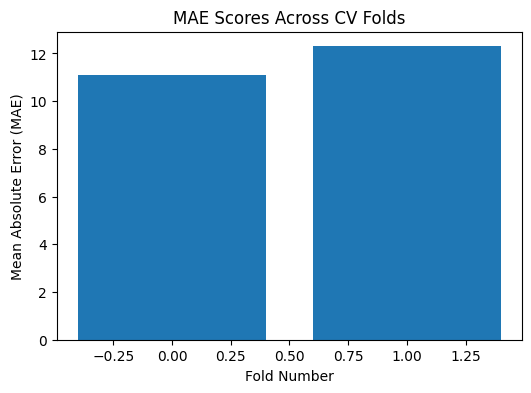

In [17]:
import matplotlib.pyplot as plt

# Plot MAE Scores
plt.figure(figsize=(6,4))
plt.bar(range(len(mae_scores)), mae_scores)
plt.xlabel("Fold Number")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE Scores Across CV Folds")
plt.show()
